# BOX-INPUT


In [1]:
import openmc
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import kdsource as kds
from mpl_toolkits.mplot3d import Axes3D as ax


#### Biblioteca de secciones eficaces

In [2]:
openmc_data = "/home/agusgimenez/KD_OPMC/Secciones/endfb-viii.0-hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

### MATERIALES

In [3]:
mat01 = openmc.Material(material_id=0) #agua
mat01.add_nuclide('H1',2.000,'ao')
mat01.add_nuclide('O16',0.9976,'ao')
mat01.add_nuclide('O17',0.00035,'ao')
mat01.add_s_alpha_beta('c_H_in_H2O')
mat01.set_density('g/cm3',1.00)


mat02 = openmc.Material(material_id=1)
mat02.add_nuclide('Cd106',1.22,'ao')
mat02.add_nuclide('Cd108',0.88,'ao')
mat02.add_nuclide('Cd110',12.39,'ao')
mat02.add_nuclide('Cd111',12.75,'ao')
mat02.add_nuclide('Cd112',24.07,'ao')
mat02.add_nuclide('Cd113',12.26,'ao')
mat02.add_nuclide('Cd114',28.86,'ao')
mat02.add_nuclide('Cd116',7.58,'ao')
mat02.set_density('g/cm3',8.65)


### PARAMETROS DE GEOMETRIAS


In [4]:

#bloque mat01
W =5.0 #semi-ancho
H =5.0 #semi-alto
L =1.0 #largo 

#bloque donde quiero ver la lista de particulas
angle = math.radians(30)

# #bloque mat02
# e_cd =1.0 #espesor
# w_cd =0.1 #ancho de cada bloque
# if w_cd>W/2:
#     exit


#FUENTE
R = 1.0



### GEOMETRIAS


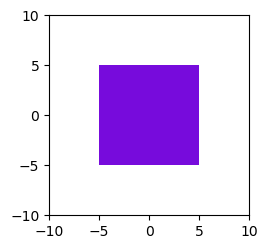

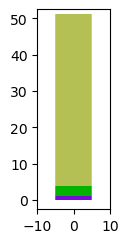

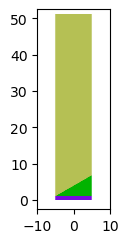

In [5]:

#bloque mat01
surf1 = openmc.XPlane(-W)
surf1.boundary_type = 'vacuum'

surf6 = openmc.XPlane(W)
surf6.boundary_type = 'vacuum'

surf2 = openmc.YPlane(-H)
surf2.boundary_type = 'vacuum'

surf5 = openmc.YPlane(H)
surf5.boundary_type = 'vacuum'


surf3 = openmc.ZPlane(0)
surf3.boundary_type = 'vacuum'

surf4 = openmc.ZPlane(L)

surf7 = openmc.ZPlane(51*L)
surf7.boundary_type = 'vacuum'




cell01 = openmc.Cell(fill=mat01,cell_id=1)
cell01.region = +surf1 & -surf6 & +surf2 & -surf5 & +surf3 & -surf4


#source.hs
surf_source = openmc.Plane.from_points((-W,-H,L),(-W,H,L),(0.0,0.0,L+W*math.sin(angle)/math.cos(angle)))
cell02 = openmc.Cell(fill=None,cell_id=2)
cell02.region = +surf4 & +surf_source & +surf1 & -surf6 & +surf2 & -surf5


cell00 = openmc.Cell(fill=None,cell_id=0)
cell00.region = -surf7 & -surf_source & +surf1 & -surf6 & +surf2 & -surf5


univ01 = openmc.Universe(cells=[cell00,cell01, cell02],universe_id=1) 
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W,4*W))
univ01.plot(origin=(0.0,0.0,50*L/2),width=(4*W,55*L),basis='yz')
univ01.plot(origin=(0.0,0.0,50*L/2),width=(4*W,55*L),basis='xz')








### SOURCE

In [6]:

S = openmc.Source()
S.particle = 'neutron'
#dist_espacial'

r = openmc.stats.PowerLaw(0.0,R,1.0)
phi = openmc.stats.Uniform(0.0 , 2*math.pi)
z = openmc.stats.Discrete(0.0 , 1.0)
S.space = openmc.stats.CylindricalIndependent(r,phi,z)

#dist_Energia
S.energy = openmc.stats.Discrete(30.0,1.0)

#dist_angular.

S.angle = openmc.stats.Monodirectional(reference_uvw=[0.0,0.0,1.0])

#### Configuracion de filtros y tallys

In [7]:
tallies = openmc.Tallies()


#FILTRO PARTICULA
Filtro_particula_neutron    =   openmc.ParticleFilter(['neutron'],filter_id = 0)


#FILTRO SUPERFICIE CHECK SOURCE
Filtro_surface_source       =   openmc.SurfaceFilter(surf7.id,filter_id=7)
Filtro_Energy_source        =   openmc.EnergyFilter(np.logspace(-5,2,100),filter_id=8)

#GRILLA

mesh_agua_xy = openmc.RegularMesh.from_domain(domain=cell01,dimension=(100,100,1),mesh_id=4)
mesh_agua_xz = openmc.RegularMesh.from_domain(domain=cell01,dimension=(100,1,100),mesh_id=5)
mesh_agua_yz = openmc.RegularMesh.from_domain(domain=cell01,dimension=(1,100,100),mesh_id=6)


mesh_vacio_xy = openmc.RegularMesh.from_domain(domain=cell00,dimension=(100,100,10),mesh_id=1)
mesh_vacio_xy.lower_left = [-W, -H, L]
mesh_vacio_xy.upper_rigth = [W, H, 51*L]

mesh_vacio_xz = openmc.RegularMesh.from_domain(domain=cell00,dimension=(100,1,500),mesh_id=2)
mesh_vacio_xz.lower_left = [-W, -H, L]
mesh_vacio_xy.upper_rigth = [W, H, 51*L]

mesh_vacio_yz = openmc.RegularMesh.from_domain(domain=cell00,dimension=(1,100,500),mesh_id=3)
mesh_vacio_yz.lower_left = [-W, -H, L]
mesh_vacio_yz.upper_rigth = [W, H, 51*L]


#FILTRO ESPACIAL
filt_agua_xy = openmc.filter.MeshFilter(mesh_agua_xy,filter_id=4)
filt_agua_xz = openmc.filter.MeshFilter(mesh_agua_xz,filter_id=5)
filt_agua_yz = openmc.filter.MeshFilter(mesh_agua_yz,filter_id=6)

filt_vacio_xy = openmc.filter.MeshFilter(mesh_vacio_xy,filter_id=1)
filt_vacio_xz = openmc.filter.MeshFilter(mesh_vacio_xz,filter_id=2)
filt_vacio_yz = openmc.filter.MeshFilter(mesh_vacio_yz,filter_id=3)


#Tallys

dist_agua_xy = openmc.Tally(name='agua_xy' , tally_id=4)
dist_agua_xy.scores = ["flux"]
dist_agua_xy.filters = [filt_agua_xy, Filtro_particula_neutron]
tallies.append(dist_agua_xy)

dist_agua_xz = openmc.Tally(name='agua_xz' , tally_id=5)
dist_agua_xz.scores = ["flux"]
dist_agua_xz.filters = [filt_agua_xz, Filtro_particula_neutron]
tallies.append(dist_agua_xz)

dist_agua_yz = openmc.Tally(name='agua_yz' , tally_id=6)
dist_agua_yz.scores = ["flux"]
dist_agua_yz.filters = [filt_agua_yz, Filtro_particula_neutron]
tallies.append(dist_agua_yz)

dist_vacio_xy = openmc.Tally(name='vacio_xy' , tally_id=1)
dist_vacio_xy.scores = ["flux"]
dist_vacio_xy.filters = [filt_vacio_xy, Filtro_particula_neutron]
tallies.append(dist_vacio_xy)

dist_vacio_xz = openmc.Tally(name='vacio_xz' , tally_id=2)
dist_vacio_xz.scores = ["flux"]
dist_vacio_xz.filters = [filt_vacio_xz, Filtro_particula_neutron]
tallies.append(dist_vacio_xz)

dist_vacio_yz = openmc.Tally(name='vacio_yz' , tally_id=3)
dist_vacio_yz.scores = ["flux"]
dist_vacio_yz.filters = [filt_vacio_yz, Filtro_particula_neutron]
tallies.append(dist_vacio_yz)


dist_surface_source = openmc.Tally(name='check_source', tally_id=7)
dist_surface_source.scores = ["current"]
dist_surface_source.filters = [Filtro_surface_source, Filtro_Energy_source,Filtro_particula_neutron]
tallies.append(dist_surface_source)

#### PARAMETROS DE EJECUCION

In [8]:
#Numero de particulas 
N = int(1E6)

param = openmc.Settings()
param.source = S
param.run_mode = "fixed source"
param.batches = 1
param.particles = N

#Superficies donde escribe las particulas
# superficies = [surf4.id]

# param.surf_source_write = {
#     'surface_ids': superficies,
#     'max_particles': len(superficies)*N
# }



#### GENERACION DE ARCHIVOS XML

In [9]:

geom = openmc.Geometry(univ01)
geom.export_to_xml()

mats = openmc.Materials(univ01.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()


param.export_to_xml()

tallies.export_to_xml()


    ## RUN

In [10]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [24]:
def get_df_NormVolum(
    tally = openmc.Tally(),
    Plot = False,
    xlabel='x [cm]',
    ylabel='y [cm]'
):
    """Plot 2-D distribution for given spatial variables (xy, xz, yz)

    Returns
    -------    
    matplotlib 2-D plot for the Tally with the proper
    normalization.
    """
    
    
    
    mesh = tally.find_filter(openmc.filter.MeshFilter)
    upper_right = mesh.mesh.upper_right
    lower_left  = mesh.mesh.lower_left
    N    = mesh.mesh.dimension    
    DV   = (upper_right-lower_left)/N
    df = tally.get_pandas_dataframe()
    df['mean'] = df['mean']/(DV[0]*DV[1]*DV[2])
    
    if N[0] == 1:
        extent = (lower_left[1], upper_right[1], lower_left[2],upper_right[2])
    elif N[1] == 1:
        extent = (lower_left[0], upper_right[0], lower_left[2],upper_right[2])
    elif N[2] == 1:
        extent = (lower_left[0], upper_right[0], lower_left[1],upper_right[1])
    else: print("X")
    print(N)
    print(DV)
    if Plot == True:
        mean = np.array(df['mean'])
        if N[0] == 1:
            extent = (lower_left[1], upper_right[1], lower_left[2],upper_right[2])
            mean.shape=(N[2],N[1])
        elif N[1] == 1:
            extent = (lower_left[0], upper_right[0], lower_left[2],upper_right[2])
            mean.shape=(N[2],N[0])
        elif N[2] == 1:
            extent = (lower_left[0], upper_right[0], lower_left[1],upper_right[1])
            mean.shape=(N[1],N[0])
        else: print("X")
        
        plt.imshow(mean, origin='lower', interpolation='none', extent=extent, cmap='viridis')
        plt.colorbar()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
    return df
    
    
def get_df_NormEnergy(
    tally = openmc.Tally(),
    Plot = False,
    xlabel1='Energy [ev]',
    E0    = float
):
    """Plot 2-D distribution for given Energy variable (E , u)
    Returns
    -------    
    matplotlib 2-D plot for the Tally with the proper
    normalization.
    """
    
    df = tally.get_pandas_dataframe()
    Emax = df['energy high [eV]']
    Emin = df['energy low [eV]']
    DE = Emax-Emin
    E   = (Emax+Emin)/2
    units = '[n/s]'
    df['mean'] = df['mean']*DE
    
    if Plot == True:
        plt.plot(E,df['mean'])
        ylabel = df['score'][1] + units
        plt.ylabel(ylabel)
        plt.xlabel(xlabel1)
    return df
    


In [12]:
# estaba graficando el tally de energia, ver bien el grafico de mu y luego la copiled source

#### Se obtiene la distribucion espacial por neutron de fuente.

/home/agusgimenez/anaconda3/envs/KD_OPMC/lib/python3.9/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(100, 100, 1)
[0.1 0.1 1. ]


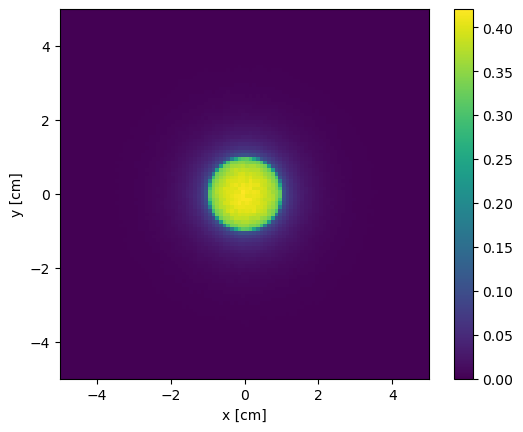

/home/agusgimenez/anaconda3/envs/KD_OPMC/lib/python3.9/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(100, 1, 500)
[ 0.1 10.   0.1]


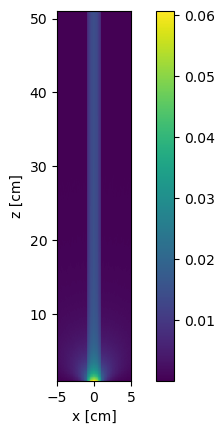

/home/agusgimenez/anaconda3/envs/KD_OPMC/lib/python3.9/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(1, 100, 100)
[10.    0.1   0.01]


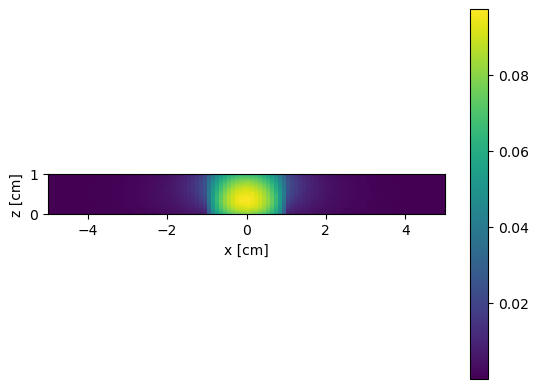

/home/agusgimenez/anaconda3/envs/KD_OPMC/lib/python3.9/site-packages/openmc/tallies.py:279: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


(1, 100, 500)
[10.   0.1  0.1]


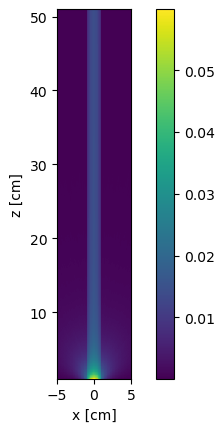

mesh 3           particle nuclide score     mean
           x    y    z                                
0          1    1    1  neutron   total  flux 9.82e-05
1          1    2    1  neutron   total  flux 1.02e-04
2          1    3    1  neutron   total  flux 1.21e-04
3          1    4    1  neutron   total  flux 1.48e-04
4          1    5    1  neutron   total  flux 1.74e-04
...      ...  ...  ...      ...     ...   ...      ...
49995      1   96  500  neutron   total  flux 8.21e-05
49996      1   97  500  neutron   total  flux 8.59e-05
49997      1   98  500  neutron   total  flux 6.28e-05
49998      1   99  500  neutron   total  flux 8.44e-05
49999      1  100  500  neutron   total  flux 8.17e-05

[50000 rows x 7 columns]

In [22]:
sp = openmc.StatePoint("statepoint.1.h5")
tally_agua_xy   = sp.get_tally(name='agua_xy')
tally_agua_xz   = sp.get_tally(name='agua_xz')
tally_agua_yz   = sp.get_tally(name='agua_yz')
tally_vacio_xy  = sp.get_tally(name='vacio_xy')
tally_vacio_xz  = sp.get_tally(name='vacio_xz')
tally_vacio_yz  = sp.get_tally(name='vacio_yz')
get_df_NormVolum(tally_agua_xy,Plot=True)
get_df_NormVolum(tally_vacio_xz,Plot=True,ylabel='z [cm]')
get_df_NormVolum(tally_agua_yz,Plot=True,ylabel='z [cm]')
get_df_NormVolum(tally_vacio_yz,Plot=True,ylabel='z [cm]')


AHORA PARA EL PLANO INCLINAD

In [14]:
# #OPTIMIZE BANDWITH
# var_importance = [3,1,1,1,1,1]

# parts,ws = S_2.plist.get(N=-1)
# scaling = S_2.geom.std(parts=parts)
# scaling /= var_importance

# # Number of particles to use for optimization.
# # A large number (1E5 or more) gives better bandwidths, but takes longer to
# # compute.
# N = 1E5


# S_2.bw_method = "silv"
# S_2.fit(N, scaling=scaling)

# xmlfile = "Source_2.xml"

# S_2.save(xmlfile)

# N_resampled = 1E6

# !kdtool resample "$xmlfile" -o "resampled_2" -n $N_resampled
# resampled_2 = "resampled_2.mcpl.gz"

# Plano_resampled_2 = kds.surfsource.SurfaceSourceFile('resampled_2.mcpl.gz')


In [15]:
# Plano_2.plot_distribution(vars=['x','y'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True)
#Plano_resampled_2.plot_distribution(vars=['x','y'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True)

In [16]:
#Plano_2.plot_distribution(vars=['x','y'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True)
# Plano_resampled_2.plot_distribution(vars=['x','y'],bins=[100,100], scales=['linear','linear'], norm_vars=[], info=True)

,surface,energy low [eV],energy high [eV],particle,nuclide,score,mean
0,7,0.000010,0.000012,neutron,total,current,0.0
1,7,0.000012,0.000014,neutron,total,current,0.0
2,7,0.000014,0.000016,neutron,total,current,0.0
3,7,0.000016,0.000019,neutron,total,current,0.0
4,7,0.000019,0.000023,neutron,total,current,0.0
...,...,...,...,...,...,...,...
94,7,44.306215,52.140083,neutron,total,current,0.0
95,7,52.140083,61.359073,neutron,total,current,0.0
96,7,61.359073,72.208090,neutron,total,current,0.0
97,7,72.208090,84.975344,neutron,total,current,0.0


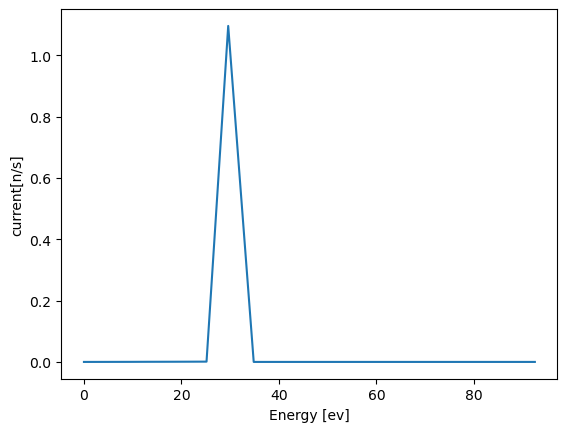

In [25]:
Ener = sp.get_tally(name='check_source')
get_df_NormEnergy(Ener,True)
# Ener.get_pandas_dataframe()['score'][1]


In [18]:
# #Numero de particulas 
# N = int(1E6)

# a = openmc.Co
# param = openmc.Settings()
# param.source = openmc.Source.CompiledSource('libsource.so')
# param.run_mode = "fixed source"
# param.batches = 1
# param.particles = N
# param.export_to_xml()


In [19]:
# !rm statepoint.*.h5
# !rm summary.h5
# openmc.run()